In [299]:
from scipy.optimize import nnls
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from sklearn.decomposition import NMF

from random import sample

from functions import cosine_perm, simulate_mixedBIG, simulate_mixedLittle, simulate_counts
from AAUtoSig_init import AAUtoSig, train_AAUtoSig

## Split data
Firstly we write a method to split the mutational profile matrix into a training and validation set.

In [300]:
def split_data(data, frac_1):
  x_train = data.sample(frac = frac_1)
  x_validation = data.drop(x_train.index)
  return x_train, x_validation

# NMF performance

In [301]:
def out_errorNMF(train_df, validation_df, nsigs ,true_sigs):
  model = NMF(n_components=nsigs, init='random', max_iter = 500)
  exposures = model.fit_transform(train_df)
  signatures = model.components_
  cos_NMF = cosine_perm(true_sigs.to_numpy().T, signatures)[0]
  cos_mean = np.mean(cos_NMF.diagonal())


  ref_exposures = model.transform(X = validation_df)
  rec = np.dot(ref_exposures, signatures)
  MSE = np.mean(((validation_df - rec)**2).to_numpy())

  return([cos_mean, MSE])

# AAUtoSig performance

In [302]:
def out_error_AAUtoSig(train_df, validation_df, nsigs, true_sigs):
    model = AAUtoSig(nsigs)

    # Validation using MSE Loss function
    loss = torch.nn.MSELoss(reduction='mean')

     # Using an Adam Optimizer with lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(),
                            lr = 1e-3)
    train_AAUtoSig(500, model, train_df, loss_function= loss, optimizer=optimizer, batch_size= 32)

    signatures = model.dec1.weight.data    
    #signatures = pd.DataFrame(signatures.numpy())
     
    cos_Deep = cosine_perm(true_sigs.to_numpy().T, pd.DataFrame(signatures.numpy()).T)[0]
    cos_mean = np.mean(cos_Deep.diagonal())

    def calculate_exp(b):
       return(nnls(A = signatures, b = b)[0])
   
    #print(np.stack(validation_df.apply(calculate_exp, axis = 1)))
    ref_exposures = np.stack(validation_df.apply(calculate_exp, axis = 1))
    rec = np.dot(ref_exposures, signatures.T)

    MSE = np.mean(((validation_df - rec)**2).to_numpy())
    return ([cos_mean, MSE])

## Performance analysis

In [303]:
def performance_analysis(npatients, nsigs):
  mut_matrix_l, signatures_l, _ = simulate_counts(nsigs, npatients)
  train_data_l, validation_data_l = split_data(mut_matrix_l.T, 0.8)

  return(out_errorNMF(train_data_l, validation_data_l, nsigs, signatures_l) + 
          out_error_AAUtoSig(train_data_l, validation_data_l, nsigs, signatures_l))
asd = [performance_analysis(300, 7) for _ in range(10)] 
result = pd.DataFrame(asd)
result.columns = ["cosineNMF linear", "outNMF linear", "cosineAE linear", "outAE linear"]


C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


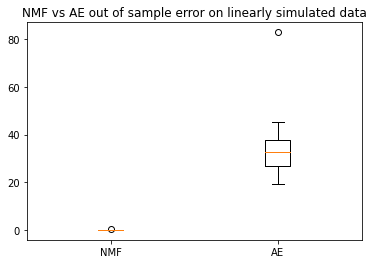

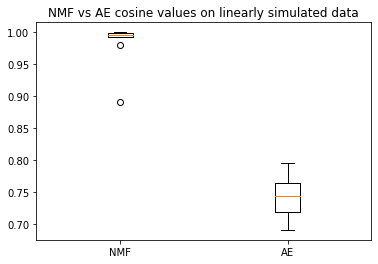

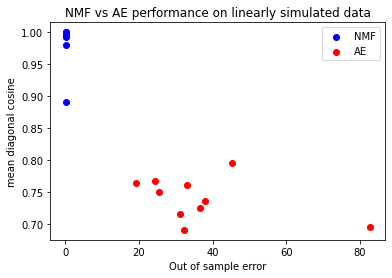

KeyError: "None of [Index(['outNMF nonlinear', 'outAE nonlinear'], dtype='object')] are in the [columns]"

In [304]:
plt.boxplot(result[['outNMF linear', 'outAE linear']], labels = ["NMF", "AE"])
plt.title('NMF vs AE out of sample error on linearly simulated data')
plt.show()

plt.boxplot(result[['cosineNMF linear', 'cosineAE linear']] ,labels = ["NMF", "AE"])
plt.title('NMF vs AE cosine values on linearly simulated data')
plt.show()

plt.scatter(y = result['cosineNMF linear'], x = result['outNMF linear'], c = 'blue', label = 'NMF')
plt.scatter(y = result['cosineAE linear'], x = result['outAE linear'], c = 'red', label = 'AE')
plt.xlabel('Out of sample error')
plt.ylabel('mean diagonal cosine')
plt.title('NMF vs AE performance on linearly simulated data')
plt.legend()
plt.show()
#plt.savefig('linear.png', transparent=True)